In [1]:
import os
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sbn


In [2]:
df = pd.read_csv('../exports/online_retail_cleaningdata.csv')

In [3]:
df.head()

,Unnamed: 0,invoice_id,item_id,description,quantity,date,unit_price,sales,customer_id,country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,15.30,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,20.34,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,22.00,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,20.34,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,20.34,17850.0,United Kingdom


In [4]:
df.isnull().sum()

Unnamed: 0     0
invoice_id     0
item_id        0
description    0
quantity       0
date           0
unit_price     0
sales          0
customer_id    0
country        0
dtype: int64

# Finding RFM values

## Recency

In [5]:
day = pd.to_datetime("2011-12-10").normalize()
df['date'] = pd.to_datetime(df['date']).dt.normalize()

In [6]:
df['date'].max() , df['date'].min()

(Timestamp('2011-12-09 00:00:00'), Timestamp('2010-12-01 00:00:00'))

In [7]:
recency = df.groupby(['customer_id']).agg({"date": lambda x:((day-x.max()).days)}).reset_index()
recency = recency.rename(columns={'date': 'recency'})
recency

,customer_id,recency
0,12347.0,3
1,12348.0,76
2,12349.0,19
3,12350.0,311
4,12352.0,37
...,...,...
4285,18280.0,278
4286,18281.0,181
4287,18282.0,8
4288,18283.0,4


In [8]:
df.customer_id.unique().shape

(4290,)

## Ferequency (In Two Ways)

In [9]:
frequency_1 = df.drop_duplicates(subset ='invoice_id').groupby(['customer_id'])[['invoice_id']].count()
frequency_1

,invoice_id
customer_id,
12347.0,7
12348.0,4
12349.0,1
12350.0,1
12352.0,7
...,...
18280.0,1
18281.0,1
18282.0,2


In [10]:
frequency = df.groupby(['customer_id'])[['invoice_id']].nunique().reset_index()
frequency = frequency.rename(columns={'invoice_id' : 'frequency'})
frequency.head()

,customer_id,frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,7


## Monetary

In [11]:
monetary = df.groupby(['customer_id'])[['sales']].sum().reset_index()
monetary = monetary.rename(columns={'sales' : 'monetary'})
monetary.head()

,customer_id,monetary
0,12347.0,4060.40
1,12348.0,1186.68
2,12349.0,1353.80
3,12350.0,294.40
4,12352.0,1385.74


## RFM Values

In [13]:
rfm_values = recency.merge(frequency, on='customer_id')
rfm_values = rfm_values.merge(monetary, on='customer_id')

rfm_values.head()


,customer_id,recency,frequency,monetary
0,12347.0,3,7,4060.40
1,12348.0,76,4,1186.68
2,12349.0,19,1,1353.80
3,12350.0,311,1,294.40
4,12352.0,37,7,1385.74


In [14]:
rfm_values.isnull().sum()

customer_id    0
recency        0
frequency      0
monetary       0
dtype: int64

In [15]:
rfm_sorted = rfm_values.sort_values('monetary' , ascending=False)
rfm_sorted.head()

,customer_id,recency,frequency,monetary
1676,14646.0,3,64,158967.80
1866,14911.0,2,198,125132.11
3736,17511.0,3,30,73056.39
1323,14156.0,10,51,70571.29
54,12415.0,25,15,67004.37


## CLV Historical

In [16]:
df.head()

,Unnamed: 0,invoice_id,item_id,description,quantity,date,unit_price,sales,customer_id,country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,15.30,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,20.34,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,22.00,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,20.34,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,20.34,17850.0,United Kingdom


In [17]:
clv_historical = df.groupby('customer_id')[['sales']].sum().reset_index()
clv_historical.columns = ['customer_id', 'clv_historical']
clv_historical.sort_values(by = 'clv_historical' , ascending = False)

,customer_id,clv_historical
1676,14646.0,158967.80
1866,14911.0,125132.11
3736,17511.0,73056.39
1323,14156.0,70571.29
54,12415.0,67004.37
...,...,...
2989,16454.0,6.90
1780,14792.0,6.20
2971,16429.0,4.95
3189,16738.0,3.75


In [18]:
rfm_clv = rfm_values.merge(clv_historical , on = 'customer_id' , how = 'left')
rfm_clv.head()

,customer_id,recency,frequency,monetary,clv_historical
0,12347.0,3,7,4060.40,4060.40
1,12348.0,76,4,1186.68,1186.68
2,12349.0,19,1,1353.80,1353.80
3,12350.0,311,1,294.40,294.40
4,12352.0,37,7,1385.74,1385.74


In [19]:
relevant_cols = ["recency", "frequency", "monetary" , "clv_historical"]
rfm_clv_n = rfm_clv[relevant_cols]

In [20]:
rfm_clv_n.head()

,recency,frequency,monetary,clv_historical
0,3,7,4060.40,4060.40
1,76,4,1186.68,1186.68
2,19,1,1353.80,1353.80
3,311,1,294.40,294.40
4,37,7,1385.74,1385.74


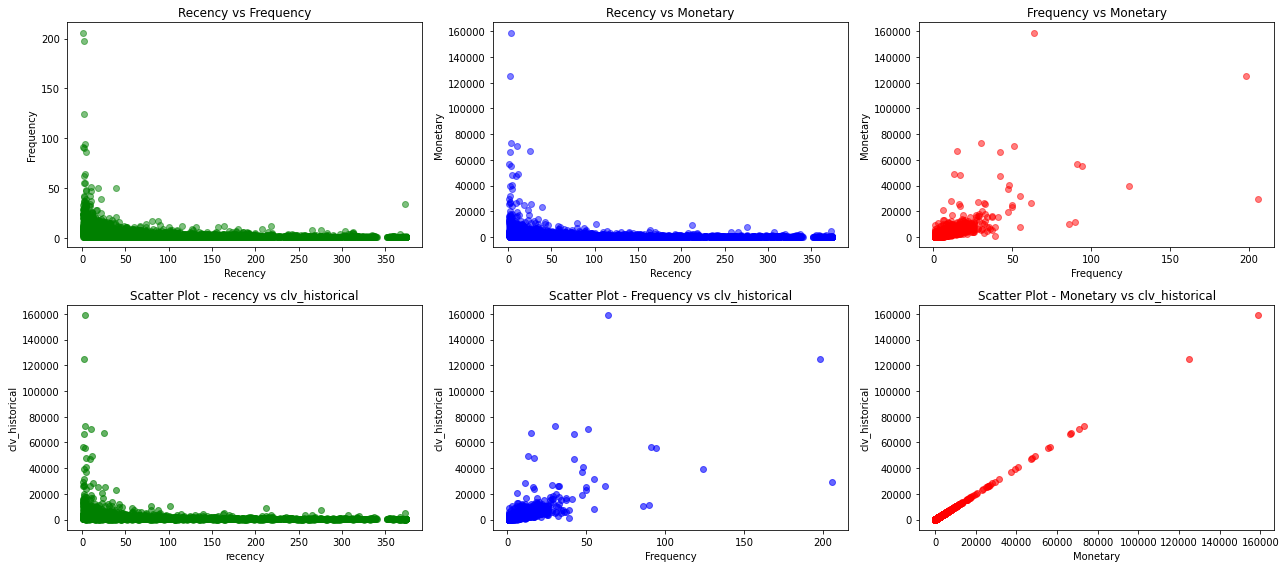

In [21]:
plt.figure(figsize=(18,8))

# Recency vs Frequency
plt.subplot(2, 3, 1)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['frequency'], color='green', alpha=0.5)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency')

# Recency vs Monetary
plt.subplot(2, 3, 2)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['monetary'], color='blue', alpha=0.5)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Recency vs Monetary')

# Frequency vs Monetary
plt.subplot(2, 3, 3)
plt.scatter(rfm_clv_n['frequency'], rfm_clv_n['monetary'], color='red', alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Frequency vs Monetary')

# recency vs clv_historical
plt.subplot(2, 3, 4)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['clv_historical'], color='green', alpha=0.6)
plt.xlabel('recency')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - recency vs clv_historical')

# Frequency vs clv_historical
plt.subplot(2, 3, 5)
plt.scatter(rfm_clv_n['frequency'], rfm_clv_n['clv_historical'], color='blue', alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - Frequency vs clv_historical')

# Frequency vs clv_historical
plt.subplot(2, 3, 6)
plt.scatter(rfm_clv_n['monetary'], rfm_clv_n['clv_historical'], color='red', alpha=0.6)
plt.xlabel('Monetary')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - Monetary vs clv_historical')


plt.tight_layout()
plt.show()


In [22]:
rfm_clv.to_csv('../exports/online_retail_rfm_clv(historical)_realdata.csv')

In [23]:
rfm_clv.to_excel('../exports/online_retail_rfm_clv(historical)_realdata.xlsx')

In [24]:
rfm_clv_n

,recency,frequency,monetary,clv_historical
0,3,7,4060.40,4060.40
1,76,4,1186.68,1186.68
2,19,1,1353.80,1353.80
3,311,1,294.40,294.40
4,37,7,1385.74,1385.74
...,...,...,...,...
4285,278,1,180.60,180.60
4286,181,1,46.92,46.92
4287,8,2,178.05,178.05
4288,4,16,2078.93,2078.93
